In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from student import NearestNeighbor, load_cifar10, validate_shapes
from subprocess import Popen
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
x_train, y_train, x_test, y_test = load_cifar10()

In [6]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


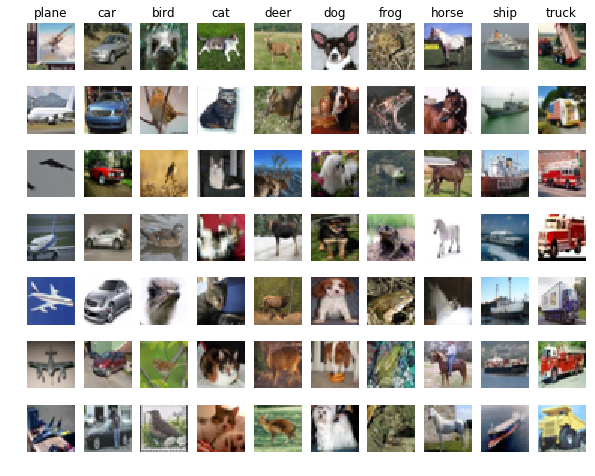

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for label_ind, cls in enumerate(classes):
    idxs = np.where(y_train == label_ind)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + label_ind + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Lets use a small fraction of the data to speed up our code development
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:500], y_test[:500]
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (5000, 32, 32, 3)
Training labels shape:  (5000,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)


In [9]:
# Finally, let's reshape each data point into a single vector
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, x_test.shape)

(5000, 3072) (500, 3072)


# Question 1
Open up `student.py` and write code that fills the specifications in `compute_distances`. Your code will be called like this
```python
classifier = NearestNeighbor()
classifier.train(x_train, y_train)  # This just remembers all of the samples
dists = classifier.compute_distances(X)  # X is an (N x 3072) numpy array
```
Your ouput should have the following properties
* `dists` is a `np.array` with shape `(X.shape[0], x_train.shape[0])`
* `dists[i, j]` = the L2 distance between `X[i]` and `x_train[j]`
* `compute_distances` _avoids_ using two explicit loops to calculate this distance (it's very slow), instead opting for at least a one-loop implementation as demonstrated in the reading. In Python module 4, you will compute this distance in a vectorized way with _no_ explicit loops, which is very fast.
* `compute_distances` should work for arbitrary `x_train` and `X`, as long as they have the same number of columns (i.e. you should _not_ explicitly require 3072 columns in your implementation)

** Use the output of the cell below to answer question 1 of the homework **

In [20]:
%%bash
python grade_compute_distances.pyz

================================= TESTS PASSED =================================
Output has the correct shape
Output is correct

============================== ALL TESTS PASSED!  ==============================
Your submission code: bwa64e37828749bde2b696156d8cabba76bdf4a5587a5f7402bc25666e


# Question 2
Let's use `x_test` to examine the output of `compute_distances`.

** Use the output of the cells below to answer question 2 of the homework **

NOTE: Question 2 has multiple parts

In [21]:
classifier = NearestNeighbor()
classifier.train(x_train, y_train)

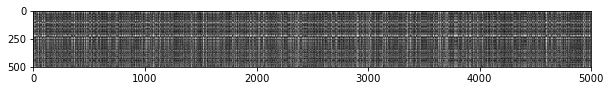

In [22]:
dists = classifier.compute_distances(x_test)
plt.imshow(dists, interpolation='none')
plt.show()

# Question 3
Open up `student.py` and write code that fills the specifications in `predict`. Your code will be called like this
```python
classifier = NearestNeighbor()
classifier.train(x_train, y_train)
pred = classifier.predict(X, k=5)
```
Your code should have the following characteristics
* If `X` is an MxN array, `pred` is an array of M labels
* For each image in `X`, the `k` nearest neighbors should vote on the label (the label with the most votes wins)
* If there is a tie, the _smallest_ of the tied labels should win

** Strategies **
* Divide your work into manageable chunks -- we recommend the following approach
  * Use your `compute_distances` function to find the k nearest neighbors to each image in X (look into [np.argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html))
  * Use `self.ytr` to get the labels of those neighbors
  * For each image, find the most frequent value among those labels & apply the tie-breaking rule listed above
* Test your approach on smaller data
  * `np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])` is a perfectly good example
  * Create a new classifier with a small dataset using `new_classifier = NearestNeighbor(); new_classifier.train(new_x, new_y)`

** Use the output from the cell below to answer question 3 of the homework **

In [23]:
%%bash
python grade_predictions.pyz

================================= TESTS PASSED =================================
Output has the correct shape
Output breaks vote ties appropriately
Output is correct

============================== ALL TESTS PASSED!  ==============================
Your submission code: bw4a5a740136906ca9420c5cabb4dc1527f96cb641fb11083f960aff69


# Question 4 - Choosing Hyperparameters
Hyperparameters are distinguished from "normal" parameters in machine learning because they are never _optimized_ numerically during training. Instead, they are set manually by the engineer who is training the model. However, this does not imply that you should choose hyperparameters without any sort of method. You are about to demonstrate one of the most common methods for choosing hyperparameters: _cross validation_.

In cross validation, segments of the training data are temporarily separated for intermediate "testing" of the hyperparameter selection. The hyperparameters that perform the best across all "folds" of the training data are then selected for the final evaluation on the test data.

The k-nearest-neighbor has a single hyperparameter, _k_, which we will now set using cross validation.

Feel free to use the utility function `validate_shapes` to make sure you're creating your folds correctly.

### NOTE
You _can_ complete this section after having only read the K-nearest neighbors reading material, however, it will run very slow. If you are impatient please read Python Module 4 (Advanced NumPy), particularly the section on broadcasting and distance calculations.

In [24]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
frac = x_train.shape[0]//num_folds
x_train_folds = [x_train[i*frac:(i+1)*frac] for i in range(num_folds)]
y_train_folds = [y_train[i*frac:(i+1)*frac] for i in range(num_folds)]

In [ ]:
accuracies = dict()
for k in k_choices:
    print('k = {}'.format(k))
    accuracies[k] = list()
    for i in range(num_folds):
        # STUDENT CODE GOES HERE
        # Create x_train_fold, y_train_fold, x_val_fold and y_val_fold
        # for num_folds == 5
        #    x_train_fold.shape = (4000, 3072)
        #    y_train_fold.shape = (4000,)
        #    x_val_fold.shape = (1000, 3072)
        #    y_val_fold.shape = (1000,)
        # 
        # HINT: Look at the documentation for numpy.vstack
        x_train_fold = np.vstack((x_train_folds[j] for j in np.delete(np.arange(num_folds), i)))
        y_train_fold = np.hstack((y_train_folds[j] for j in np.delete(np.arange(num_folds), i)))
        #    print(x_train_fold.shape, y_train_fold.shape)
        x_val_fold = x_train_folds[i]
        y_val_fold = y_train_folds[i]
        #    print(x_val_fold.shape, y_val_fold.shape)
        
        # Optional
        validate_shapes(x_train_fold, y_train_fold, x_val_fold, y_val_fold)
        
        # STUDENT CODE GOES HERE
        # Evaluate the accuracy of your classifier, trained with x_train_fold and
        # tested on x_val_fold. Append the accuracy (0.00 <= acc <= 1.00) to accuracies[k]
        classifier = NearestNeighbor()
        classifier.train(x_train_fold, y_train_fold)
        y_pred = classifier.predict(classifier.compute_distances(x_val_fold), k = k)
        acc = np.mean(y_pred == y_val_fold)
        print(acc)
        accuracies[k].append(acc)

k = 1
0.263
0.257
0.264
0.278
0.266
k = 3
0.239
0.249
0.24
0.266
0.254
k = 5
0.248
0.266
0.28
0.292
0.28
k = 8
0.262
0.282
0.273
0.29
0.273
k = 10
0.265
0.296
0.276
0.284
0.28
k = 12
0.26
0.295
0.279
0.283
0.28
k = 15
0.252
0.289
0.278
0.282
0.274
k = 20
0.27
0.279
0.279
0.282
0.285
k = 50
0.271
0.288
0.278
0.269
0.266
k = 100
0.256
0.27
0.263
0.256


When you run the cell below, you should see a plot that looks an awful lot like the [example from the required reading](https://cs231n.github.io/classification/) (towards the bottom of the text).

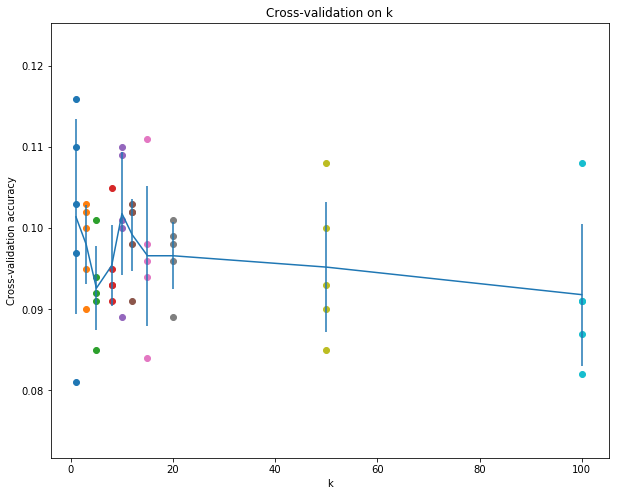

In [49]:
for k in k_choices:
    plt.scatter([k] * len(accuracies[k]), accuracies[k])

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

** Use this output to answer the rest of the questions in the homework **